In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import utils.multicrop_dataset as multicrop_dataset
import utils.architecture as architecture

tf.random.set_seed(0)
np.random.seed(0)

options = tf.data.Options()
options.experimental_optimization.noop_elimination = True             # eliminate no-op transformations
tf.compat.v1.data.experimental.OptimizationOptions.map_vectorization = True    # vectorize map transformations
options.experimental_optimization.apply_default_optimizations = True  # apply default graph optimizations
options.experimental_deterministic = True                            # False disable deterministic order
options.threading.max_intra_op_parallelism = 1           # overrides the maximum degree of intra-op parallelism 

In [29]:
import xarray as xr
import numpy as np
from time import sleep

def open_nc(file_path):

    try:
        ds = xr.open_dataset(file_path)

    except Exception as e:
        print(f"Error opening file: {e}")
        return 

    else:
        return ds
    
def save_values(variable, file= 'data/msl_t2m_1983_2023.nc',wind = 5):
    #just to save process

    ds = open_nc(file)
    df = ds[variable].values

    q99 = np.quantile(df,0.99)
    q10 = np.quantile(df,0.1)

    norm_imgs = np.clip(df, q10, q99)
    norm_imgs = (norm_imgs - q10)/(q99 -q10)

    time, lat, long = norm_imgs.shape

     #find best after

    norm_imgs = norm_imgs.reshape(int(time/wind), wind, lat, long)
    norm_imgs = np.transpose(norm_imgs, (0, 2, 3, 1))

    # np.save(f'data/{variable}',norm_imgs,allow_pickle=False)
    return norm_imgs

data = save_values('t2m')

In [4]:
BS = 128 
SIZE_CROPS = [50, 32]  
NUM_CROPS= [2,3]

#SCALE FOR CROPPING
MIN_SCALE = [0.7, 0.5]
MAX_SCALE = [1., 0.7]

PROTOTYPES = 15
PROPORTIONS = [] #to not use proportions declare it as empty list

#check
if len(PROPORTIONS):
    PROTOTYPES = len(PROPORTIONS)

MODEL_TAG  = ''

In [30]:
# data = np.load('data/test.npy')
data_tensors = tf.data.Dataset.from_tensor_slices(data) 

# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(data_tensors,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

trainloaders_zipped = (
        trainloaders_zipped
        .batch(BS)
        .prefetch( tf.data.experimental.AUTOTUNE)
    )

2024-07-10 09:20:39.886054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [23960,143,142,5]
	 [[{{node Placeholder/_20}}]]
2024-07-10 09:20:39.886425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [23960,143,142,5]
	 [[{{node Placeholder/_0}}]]


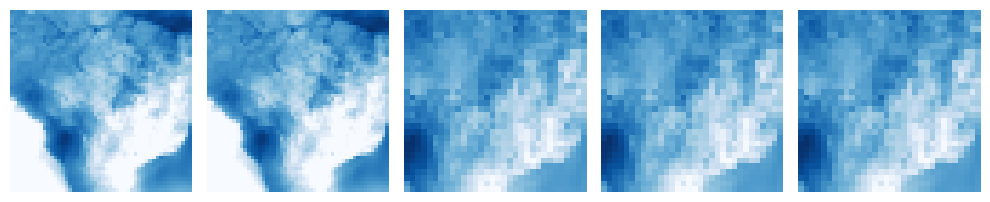

In [6]:
images = [i[3] for i in next(iter(trainloaders_zipped))]

fig, axes = plt.subplots(1, 5, figsize=(10, 7))

for ax, img in zip(axes.ravel(), images):
    ax.imshow(img,cmap='Blues')
    ax.axis('off')

# If there are more axes than images, turn off the remaining axes
for ax in axes.ravel()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(prototype_dimension = PROTOTYPES)

In [8]:
feature_backbone.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 encoder (Functional)        (None, None, None, 512)   11182080  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 11,182,080
Trainable params: 11,172,480
Non-trainable params: 9,600
_________________________________________________________________


In [9]:
projection_prototype.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                98400     
                                                                 
 tf.math.l2_normalize (TFOpL  (None, 96)               0         
 ambda)                                                    

In [10]:
decay_steps = 1000

lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [11]:
# tf.keras.backend.clear_session()

In [16]:
feature_backbone.load_weights(f'model_weights/feature2d_.h5')
projection_prototype.load_weights(f'model_weights/proj2d_.h5')

In [ ]:
epoch_wise_loss, models_tr = architecture.train_swav(feature_backbone,projection_prototype,
                                        trainloaders_zipped,opt,
                                        crops_for_assign=[0, 1],temperature=0.1,epochs=100,
                                        n_crops = NUM_CROPS, proto_proportions = PROPORTIONS,model_name=str(PROTOTYPES))

feature_backbone_weights = feature_backbone.get_weights()

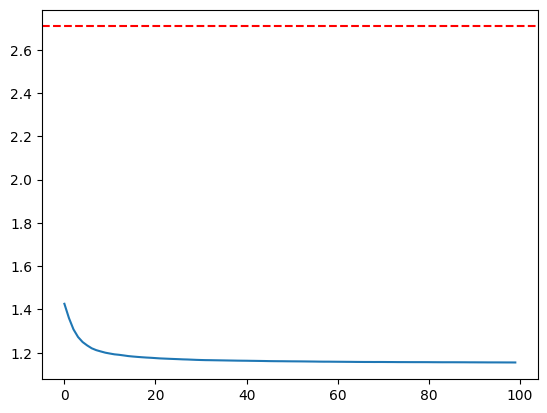

In [20]:
plt.plot(epoch_wise_loss, label='Epoch-wise Loss')
plt.axhline(y=np.log(PROTOTYPES), color='r', linestyle='--', label='ln(#prototypes)')

plt.show()

## Get assigments:

In [ ]:
from scipy.special import softmax

In [45]:
final_data = []
for sample in data:

    for v in range(sample.shape[-1]):
        final_data.append(sample[:,:,v])

In [57]:
blocks=100
size = int(len(final_data)/blocks)

for i in range(blocks):

    embeddings_ = feature_backbone(np.asarray(final_data)[i*size:(i+1)*size])
    projection_, prototype_ = projection_prototype(embeddings_)

    if i == 0:
        prototype=np.asarray(prototype_)
    else:
        prototype=np.concatenate([prototype,np.asarray(prototype_)])

prototype = np.asarray(prototype)
del projection_,embeddings_

assignments = np.argmax(softmax(prototype),axis=1)
np.save(f'model_weights/assignments_{PROTOTYPES}',assignments,allow_pickle=False)

2024-07-10 11:27:41.378366: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
